# Create a venn diagram of which alg classes "win"

In [8]:
# get tuned alg results for each split separately

import pandas as pd
import numpy as np
from pathlib import Path 

metadataset_df = pd.read_csv("./cleaned_results/tuned_aggregated_results.csv")

# make sure that the output folder exists
output_folder = Path("./venn_diagram")
output_folder.mkdir(exist_ok=True)    

# Develop outcome measures for each dataset split

In [9]:
metadataset_df["alg_type"]

0       gbdt
1       gbdt
2       gbdt
3       gbdt
4       gbdt
        ... 
2748    gbdt
2749    gbdt
2750    gbdt
2751    gbdt
2752    gbdt
Name: alg_type, Length: 2753, dtype: object

In [10]:
# categories of each alg
print(metadataset_df.groupby("alg_type")["alg_name"].value_counts())

alg_type  alg_name     
baseline  DecisionTree     159
          KNN              158
          RandomForest     158
          LinearModel      156
          SVM              142
gbdt      XGBoost          159
          LightGBM         156
          CatBoost         155
neural    MLP-rtdl         159
          TabNet           159
          MLP              158
          ResNet           158
          VIME             158
          STG              156
          DANet            146
          FTTransformer    143
          SAINT            137
          NODE             136
Name: alg_name, dtype: int64


## get best performance for each alg type

In [11]:
# say that an alg. wins if its normalized Accuracy is >= 0.99
metric = "normalized_Accuracy__test_mean"
winning_threshold = 0.99

best_performance = metadataset_df.groupby(["dataset_name", "alg_type"])[metric].max().unstack(level=-1)
print(best_performance.head())

# get binary vectors for convenience
trees_win = (best_performance["gbdt"] >= winning_threshold).astype(int)
baseline_win = (best_performance["baseline"] >= winning_threshold).astype(int)
neural_win = (best_performance["neural"] >= winning_threshold).astype(int)

alg_type                                baseline  gbdt    neural
dataset_name                                                    
openml__APSFailure__168868              0.933116   1.0  0.925503
openml__Amazon_employee_access__34539   0.212693   1.0  0.815870
openml__Australian__146818              0.936937   1.0  0.954955
openml__Bioresponse__9910               0.845272   1.0  0.655052
openml__Click_prediction_small__190408  0.594972   1.0  0.387077


### Basic analysis of winningest algs

In [12]:
print(f"total datasets: {len(trees_win)}")

print(f"total tree wins: {sum(trees_win)} ({100. * sum(trees_win)/len(trees_win)})")
print(f"total neural wins: {sum(neural_win)} ({100. * sum(neural_win)/len(trees_win)})")
print(f"total baseline wins: {sum(baseline_win)} ({100. * sum(baseline_win)/len(trees_win)})")

total datasets: 159
total tree wins: 82 (51.57232704402516)
total neural wins: 78 (49.056603773584904)
total baseline wins: 53 (33.333333333333336)


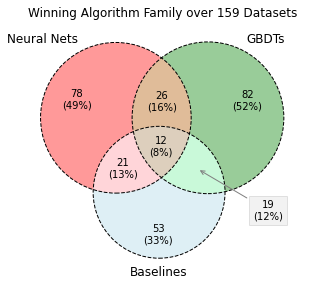

In [16]:
# plot the above as a venn diagram
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt

fix, ax = plt.subplots(figsize=(4.5, 4.5))
# ordering of subsets is (Abc, aBc, ABc, abC, AbC, aBC, ABC)
# here, A = Neural, B = Trees, C = Baseline
Abc = sum(neural_win)
aBc = sum(trees_win)
abC = sum(baseline_win)
ABc = sum(neural_win * trees_win)
aBC = sum(trees_win * baseline_win)
AbC = sum(neural_win * baseline_win)
ABC = sum(neural_win * baseline_win * trees_win)

Abc_text = f"{Abc}\n({np.round(100. * Abc / len(trees_win),0):.0f}%)"
aBc_text = f"{aBc}\n({np.round(100. * aBc / len(trees_win),0):.0f}%)"
abC_text = f"{abC}\n({np.round(100. * abC / len(trees_win),0):.0f}%)"
ABc_text = f"{ABc}\n({np.round(100. * ABc / len(trees_win),0):.0f}%)"
AbC_text = f"{AbC}\n({np.round(100. * AbC / len(trees_win),0):.0f}%)"
aBC_text = f"{aBC}\n({np.round(100. * aBC / len(trees_win),0):.0f}%)"
ABC_text = f"{ABC}\n({np.round(100. * ABC / len(trees_win),0):.0f}%)"

v = venn3(subsets=(Abc, aBc, ABc, abC, AbC, aBC, ABC), set_labels=('Neural Nets', 'GBDTs', 'Baselines'), ax=ax, set_colors=('r', 'g', 'lightblue'))
c = venn3_circles(subsets=(Abc, aBc, ABc, abC, AbC, aBC, ABC), linestyle='dashed', linewidth=1.0)

v.get_label_by_id('100').set_text(Abc_text)
v.get_label_by_id('010').set_text(aBc_text)
v.get_label_by_id('001').set_text(abC_text)
v.get_label_by_id('110').set_text(ABc_text)
v.get_label_by_id('101').set_text(AbC_text) 
v.get_label_by_id('011').set_text("")  # moved outside of box
v.get_label_by_id('111').set_text(ABC_text)

# move aBC_text outside of box
ax.annotate(aBC_text, xy=v.get_label_by_id('011').get_position() - np.array([0, 0.00]), xytext=(70,-50),
             ha='center', textcoords='offset points', bbox=dict(fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->',color='gray'))


ax.set_title(f"Winning Algorithm Family over {len(trees_win)} Datasets")

plt.tight_layout()
plt.savefig(output_folder / "winning_venn.pdf", bbox_inches=0)